# Predição de Temperatura com LSTM - TinyML

**Projeto:** Sistema de Predição de Temperatura para Microcontroladores

**Objetivo:** Prever a temperatura do sensor AHT20 em 5, 10 e 15 minutos no futuro

**Sensores utilizados:**
- AHT20: Temperatura e Umidade
- BMP280: Temperatura e Pressão

**Modelo:** LSTM (Long Short-Term Memory) compatível com TensorFlow Lite Micro

**Deploy:** Raspberry Pi Pico (RP2040)

---

# 1. Carregar os Dados

---

In [1]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# TensorFlow e Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Sklearn para pré-processamento e métricas
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import joblib

# Configuração de visualização
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Configurar seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f'TensorFlow: {tf.__version__}')
print(f'Seed configurado: {SEED}')

TensorFlow: 2.20.0
Seed configurado: 42


In [2]:
#Carregar o dataset de temperatura em lê csv
df_raw = pd.read_csv('data/temp.csv')
df_raw['Timestamp'] = pd.to_datetime(df_raw['Timestamp'])#converter coluna de timestamp para datetime
print(f'Shape original: {df_raw.shape}')
print(f'Colunas disponíveis: {list(df_raw.columns)}')

Shape original: (82430, 12)
Colunas disponíveis: ['Timestamp', 'Temp_MPU6050_C', 'Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa', 'Temp_BMP180_C', 'Press_BMP180_hPa', 'Temp_DS18B20_C', 'Temp_NTC_C', 'Temp_DHT11_C', 'Umid_DHT11_pct']


In [3]:
#Selecionar apenas as features de interesse
features = ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']
df = df_raw[['Timestamp'] + features].copy()

print(f'\nDataset filtrado:')
print(f'Shape: {df.shape}')
print(f'Features selecionadas: {features}')
print(f'Período dos dados: {df["Timestamp"].min()} até {df["Timestamp"].max()}')
print(f'\nPrimeiras linhas:')
df.head()


Dataset filtrado:
Shape: (82430, 5)
Features selecionadas: ['Temp_AHT20_C', 'Umid_AHT20_pct', 'Temp_BMP280_C', 'Press_BMP280_hPa']
Período dos dados: 2025-08-31 22:31:02 até 2025-09-30 16:52:09

Primeiras linhas:


,Timestamp,Temp_AHT20_C,Umid_AHT20_pct,Temp_BMP280_C,Press_BMP280_hPa
0,2025-08-31 22:31:02,19.90,73.37,21.28,921.24
1,2025-08-31 22:31:33,19.97,75.57,21.48,921.12
2,2025-08-31 22:32:05,19.75,74.31,21.25,921.20
3,2025-08-31 22:32:36,19.55,74.77,21.07,921.15
4,2025-08-31 22:33:07,19.60,75.09,21.12,921.25


# 2. Pré-processamento dos Dados

---

In [4]:
# Criar df_clean 
df_clean = df.copy()

#: aplicar remoção de outliers 
for col in features:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f'Depois: {len(df_clean)} amostras')
removed = len(df) - len(df_clean)
print(f'Removidos: {removed} ({100*removed/len(df):.2f}%)')

Depois: 82430 amostras
Removidos: 0 (0.00%)


## 2.1. Criar Sequências Temporais

**Conceito:** Transformar dados tabulares em sequências 3D para LSTM

**Formato:**
- Input (X): Janela de 10 timesteps com 4 features cada
- Output (y): Temperatura futura em 3 horizontes (5, 10, 15 minutos)

**Exemplo:**
```
X = [timestep_0, timestep_1, ..., timestep_9]  <- 10 timesteps passados
y = [temp_t+10, temp_t+19, temp_t+29]           <- 3 previsões futuras
```

In [5]:
#Configurar parâmetros das sequências
WINDOW_SIZE = 10 #Tamanho janela
HORIZONS = [10, 19, 29] # tempo para cada previsao (5 minutos, 10 minutos, 15 minutos)
print(f'  - Prever temperatura em {HORIZONS[0] * 31 / 60:.1f}, {HORIZONS[1] * 31 / 60:.1f} e {HORIZONS[2] * 31 / 60:.1f} minutos')

  - Prever temperatura em 5.2, 9.8 e 15.0 minutos


In [6]:
def create_sequences(data, window_size, horizons):
    """
    Criar sequências temporais para treinamento
    
    Parâmetros:
    - data: DataFrame com os dados
    - window_size: tamanho da janela de observação
    - horizons: lista de horizontes de previsão

    Retorna:
    - X: array 3D (samples, timesteps, features) -> Amostras e janelas temporais
    - y: array 2D (samples, horizons) -> TARGET É APENAS OS VALORES DE PREVISAO PARA 5, 10 E 15 MINUTOS
    """
    X, y = [], [] #armazenar x e y
    target = 'Temp_AHT20_C'
    
    for i in range(len(data) - window_size - max(horizons)): #itera pelos dados, parando antes do final para garantir espaço suficiente
        #para a janela + horizonte máximo de previsão
        X.append(data.iloc[i:i+window_size][features].values) #Seleciona apenas as colunas de features 
        #Pega uma janela de tamanho window_size começando na posição i
        y.append([data.iloc[i+window_size+h][target] for h in horizons])#Para cada horizonte em horizons (ex: [0, 5, 10]), pega o valor do target no futuro
        #i+window_size+h = posição após a janela + horizonte
        #Cria uma lista com múltiplos targets (previsões para diferentes tempos futuros)
    
    return np.array(X), np.array(y)

X, y = create_sequences(df_clean, WINDOW_SIZE, HORIZONS) #APLICA FUNÇÃO

print(f'\nX shape: {X.shape}')
print(f'  - {X.shape[0]} amostras')
print(f'  - {X.shape[1]} timesteps por amostra')
print(f'  - {X.shape[2]} features por timestep')
print(f'\ny shape: {y.shape}')
print(f'  - {y.shape[0]} amostras')
print(f'  - {y.shape[1]} horizontes de previsão')


X shape: (82391, 10, 4)
  - 82391 amostras
  - 10 timesteps por amostra
  - 4 features por timestep

y shape: (82391, 3)
  - 82391 amostras
  - 3 horizontes de previsão


## 2.2. Divisão em Treino, Validação e Teste

**Divisão:**
- Treino: 70% dos dados (para treinar o modelo)
- Validação: 15% dos dados (para ajustar hiperparâmetros)
- Teste: 15% dos dados (para avaliar desempenho final)

In [7]:
#Dividir dados em treino, validação e teste
train_size = int(0.7 * len(X))
val_size = int(0.85 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]

print('Dados divididos:')
print(f'  Treino:    {len(X_train):6d} amostras ({100*len(X_train)/len(X):.1f}%)')
print(f'  Validação: {len(X_val):6d} amostras ({100*len(X_val)/len(X):.1f}%)')
print(f'  Teste:     {len(X_test):6d} amostras ({100*len(X_test)/len(X):.1f}%)')

Dados divididos:
  Treino:     57673 amostras (70.0%)
  Validação:  12359 amostras (15.0%)
  Teste:      12359 amostras (15.0%)


## 2.3. Normalização dos Dados

**Por que normalizar?**
- Features têm escalas diferentes (temperatura ~20°C, pressão ~920 hPa)
- Redes neurais aprendem melhor com dados normalizados
- Evita que features com valores grandes dominem o treinamento

**Método:** StandardScaler (Z-score normalization)
- Transforma dados para média = 0 e desvio padrão = 1
- Fórmula: (x - média) / desvio_padrão

In [8]:
scaler = StandardScaler()# Normalizar dados usando StandardScaler

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1]) #Transforma dados 3D (amostras, timesteps, features) em 2D (amostras*timesteps, features)
#Necessário porque StandardScaler trabalha com dados 2D
scaler.fit(X_train_reshaped) #Calcula média e desvio padrão de cada feature usando APENAS dados de treino
#Aprende os parâmetros de normalização

#aplica (x - média) / desvio para cada feature
# Processo: reshape para 2D → normaliza → reshape de volta para 3D
#Os MESMOS parâmetros aprendidos no treino são aplicados em val e test
X_train_scaled = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
print(f'\nParâmetros do scaler:')
print(f'  Média (treino): {X_train_scaled.mean():.6f}')
print(f'  Desvio (treino): {X_train_scaled.std():.6f}')
print(f'\nMédias por feature:')
for i, name in enumerate(features):
    print(f'  {name:20s}: mean={scaler.mean_[i]:8.4f}, std={scaler.scale_[i]:8.4f}')


Parâmetros do scaler:
  Média (treino): 0.000000
  Desvio (treino): 1.000000

Médias por feature:
  Temp_AHT20_C        : mean= 20.2761, std=  3.2941
  Umid_AHT20_pct      : mean= 66.7186, std= 13.4807
  Temp_BMP280_C       : mean= 21.7595, std=  3.1919
  Press_BMP280_hPa    : mean=918.0153, std=  2.1066


# 3. Construção e Treinamento do Modelo

---

## 3.1. Arquitetura do Modelo LSTM

**Por que LSTM?**
- Rede recorrente projetada para capturar dependências temporais de longo prazo
- Possui 3 gates (forget, input, output) que controlam o fluxo de informação
- Mais robusta que GRU para sequências longas, porém mais pesada
- Referência clássica em séries temporais

**Arquitetura:**
```
Input (10 timesteps × 4 features)
    |
LSTM(24 unidades) + Dropout(0.2)
    |
Dense(16) + ReLU + Dropout(0.2)
    |
Dense(3) [Output: 3 previsões]
```

In [9]:
# Construir modelo LSTM
model = Sequential([
    # Camada de entrada
    Input(shape=(WINDOW_SIZE, 4)),  #Entrada: janela temporal com 4 features
    
    # Camada LSTM - processa a sequência temporal com 3 gates (forget, input, output)
    # return_sequences=False: retorna apenas o último estado oculto (vetor de 24 valores)
    # Diferente da GRU que tem 2 gates, LSTM tem 3 gates + cell state separado
    LSTM(24,
         kernel_regularizer=regularizers.l2(0.0001),#Regularização L2 para evitar overfitting
         recurrent_regularizer=regularizers.l2(0.0001),#Regularização nos pesos recorrentes
         name='lstm_1'),
    
    #Dropout para reduzir overfitting (desliga 20% dos neurônios)
    Dropout(0.2, name='dropout_1'),
    
    # Camada densa para combinar features extraídas pela LSTM
    Dense(16, activation='relu',
          kernel_regularizer=regularizers.l2(0.0001),
          name='dense_1'),
    
    #Segundo dropout
    Dropout(0.2, name='dropout_2'),
    
    #Camada de saída - 3 valores (previsões para 3 horizontes temporais)
    Dense(3, activation='linear', name='output')
], name='LSTM_Temperature')

# Compilar modelo
# clipnorm=1.0: limita a norma do gradiente para evitar explosão de gradientes (comum em redes recorrentes)
model.compile(
    optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),
    loss='mse',
    metrics=['mae']
)

print('\nArquitetura:')
model.summary()

print(f'\nTotal de parâmetros: {model.count_params():,}')


Arquitetura:


Model: "LSTM_Temperature"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24)             │         2,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235 (12.64 KB)

 Trainable params: 3,235 (12.64 KB)

 Non-trainable params: 0 (0.00 B)


Total de parâmetros: 3,235


## 3.2. Configurar Callbacks

**Callbacks** são funções que executam durante o treinamento:

1. **EarlyStopping**: Para o treinamento se a validação não melhorar
2. **ReduceLROnPlateau**: Reduz learning rate quando estagnar

In [10]:
# Configurar callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=50, #aguarda 50 epocas sem melhora no val_loss antes de parar
        restore_best_weights=True, #restaura pesos da melhor epoca
        verbose=1#mostra quando para
    ), 
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, #reduz learning rate pela metade
        patience=20, #aguarda 20 epoca sem melhorar antes de reduzir
        min_lr=1e-7, #minimo
        verbose=1 #mostrar quando reduzir
    )
]

## 3.3. Treinar o Modelo

In [11]:
history = model.fit( #treinamento modelo
    X_train_scaled, y_train, # x e y de treino sendo x o normalizado
    validation_data=(X_val_scaled, y_val), #dados de validação
    epochs=300, #300 epoca
    batch_size=512,#Pega 512 amostras do dataset, gradiente mais estavel
    callbacks=callbacks, #Callbacks mostrado acima
    verbose=1 #mostra andamento
)

Epoch 1/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 397.9184 - mae: 19.6842 - val_loss: 429.0518 - val_mae: 20.5578 - learning_rate: 5.0000e-04
Epoch 2/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 286.3716 - mae: 16.5466 - val_loss: 239.1240 - val_mae: 14.9919 - learning_rate: 5.0000e-04
Epoch 3/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 119.4341 - mae: 9.4543 - val_loss: 66.8394 - val_mae: 6.8806 - learning_rate: 5.0000e-04
Epoch 4/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 35.9565 - mae: 4.6779 - val_loss: 9.2383 - val_mae: 2.2470 - learning_rate: 5.0000e-04
Epoch 5/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 20.3444 - mae: 3.5417 - val_loss: 3.3675 - val_mae: 1.5789 - learning_rate: 5.0000e-04
Epoch 6/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.4966 - mae: 3.3035 - val_loss: 2.0392 - val_mae: 1.2072 - learning_rate: 5.0000e-04
Epoch 7/300
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 15.7575 - mae: 3.1332 - val_loss: 1.59

## 3.4. Visualizar Curvas de Aprendizado

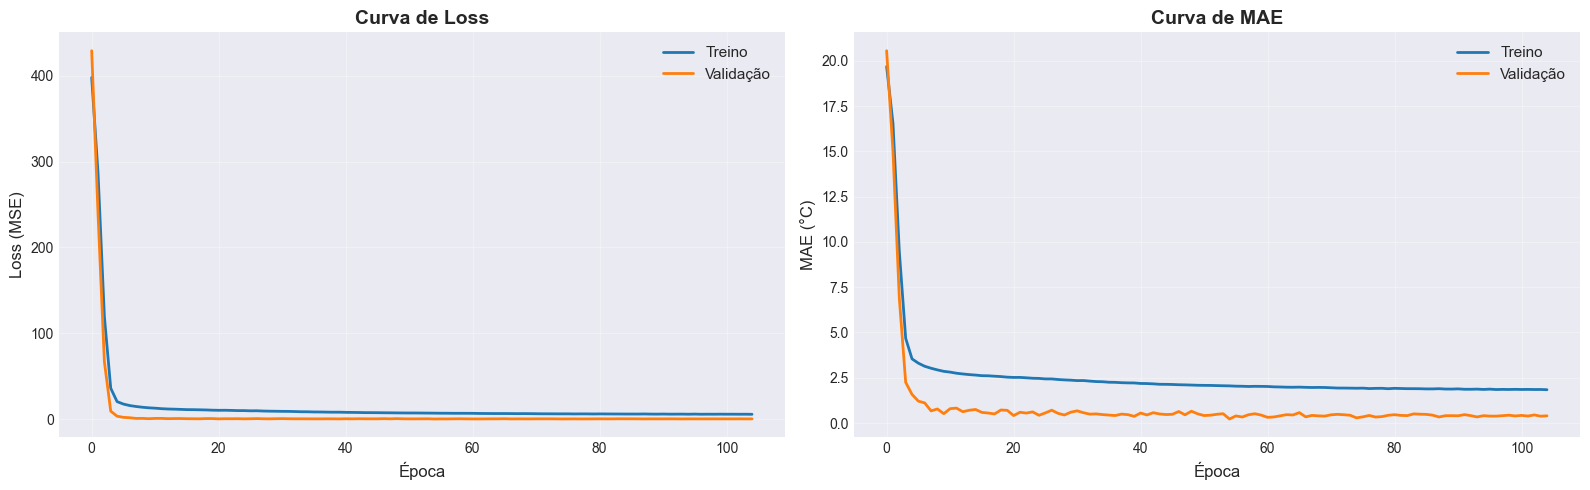

In [12]:
# Criar pasta images/LSTM se não existir
os.makedirs('images/LSTM', exist_ok=True)

# Plotar curvas de loss e MAE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Curva de Loss', fontweight='bold', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('MAE (°C)', fontsize=12)
axes[1].set_title('Curva de MAE', fontweight='bold', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/LSTM/01_curvas_aprendizado.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Avaliação do Modelo

---

## 4.1. Métricas no Conjunto de Teste

**Métricas utilizadas:**
- **MAE** (Mean Absolute Error): Erro médio absoluto em °C
- **RMSE** (Root Mean Squared Error): Raiz do erro quadrático médio
- **R²** (Coefficient of Determination): Quanto o modelo explica a variância

In [13]:
y_pred = model.predict(X_test_scaled, verbose=0)#Fazer predições no conjunto de teste
# Calcular métricas gerais no conjunto de teste
mae_overall = mean_absolute_error(y_test, y_pred)
rmse_overall = np.sqrt(mean_squared_error(y_test, y_pred))
r2_overall = r2_score(y_test, y_pred)

# Calcular MAE por horizonte
mae_t1 = mean_absolute_error(y_test[:, 0], y_pred[:, 0]) #5 minutos
mae_t2 = mean_absolute_error(y_test[:, 1], y_pred[:, 1])#10 minutos
mae_t3 = mean_absolute_error(y_test[:, 2], y_pred[:, 2]) #15 minutos

print(f'\nMétricas Gerais:')
print(f'  MAE:  {mae_overall:.4f} °C')
print(f'  RMSE: {rmse_overall:.4f} °C')
print(f'  R²:   {r2_overall:.4f}')
print(f'\nMAE por Horizonte:')
print(f'  T+10 (5 min):   {mae_t1:.4f} °C')
print(f'  T+19 (10 min):  {mae_t2:.4f} °C')
print(f'  T+29 (15 min):  {mae_t3:.4f} °C')
print(f'\nInformações do Modelo:')
print(f'  Parâmetros totais: {model.count_params():,}')


Métricas Gerais:
  MAE:  0.3264 °C
  RMSE: 0.3913 °C
  R²:   0.9881

MAE por Horizonte:
  T+10 (5 min):   0.2987 °C
  T+19 (10 min):  0.3173 °C
  T+29 (15 min):  0.3634 °C

Informações do Modelo:
  Parâmetros totais: 3,235


## 4.2. Gráficos de Predito vs Real

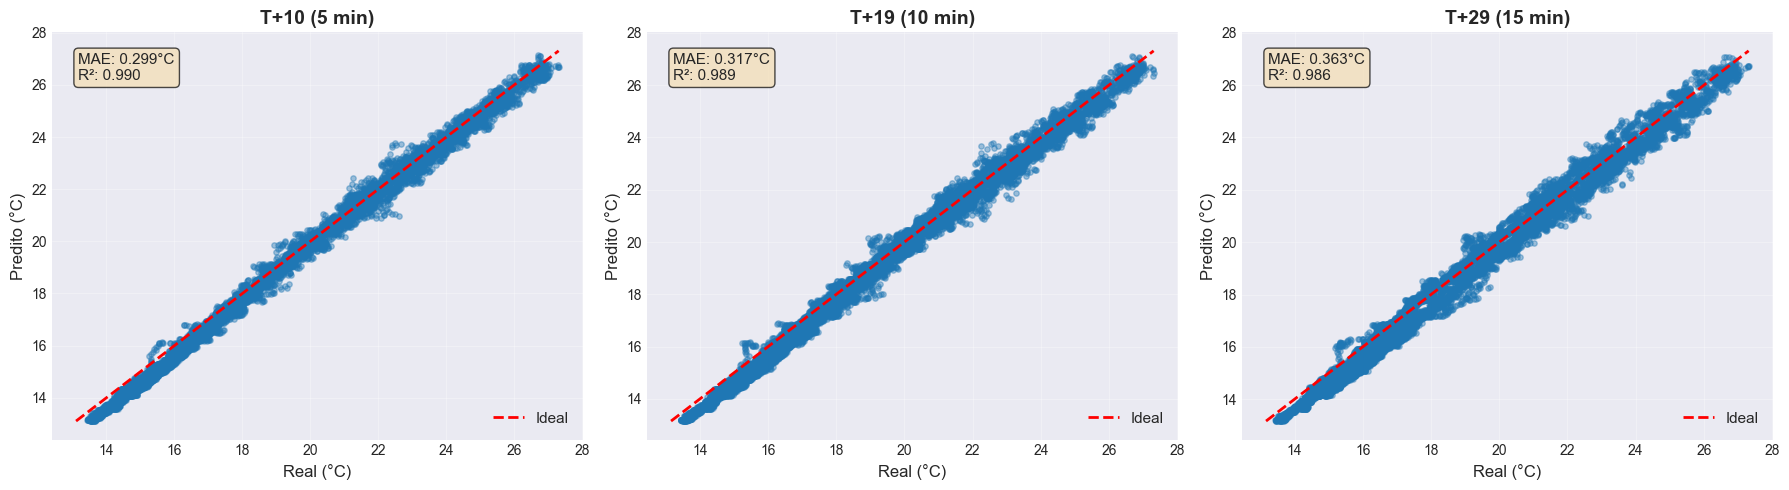

Gráfico salvo: images/LSTM/02_scatter_predictions.png


In [14]:
# Plotar scatter plots para cada horizonte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

horizons_names = ['T+10 (5 min)', 'T+19 (10 min)', 'T+29 (15 min)']

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.scatter(y_test[:, i], y_pred[:, i], alpha=0.4, s=15)
    min_val = min(y_test[:, i].min(), y_pred[:, i].min())
    max_val = max(y_test[:, i].max(), y_pred[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideal')
    ax.set_xlabel('Real (°C)', fontsize=12)
    ax.set_ylabel('Predito (°C)', fontsize=12)
    ax.set_title(horizon_name, fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    ax.text(0.05, 0.95, f'MAE: {mae:.3f}°C\nR²: {r2:.3f}',
            transform=ax.transAxes, va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.tight_layout()
plt.savefig('images/LSTM/02_scatter_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/LSTM/02_scatter_predictions.png')

## 4.3. Séries Temporais de Predições

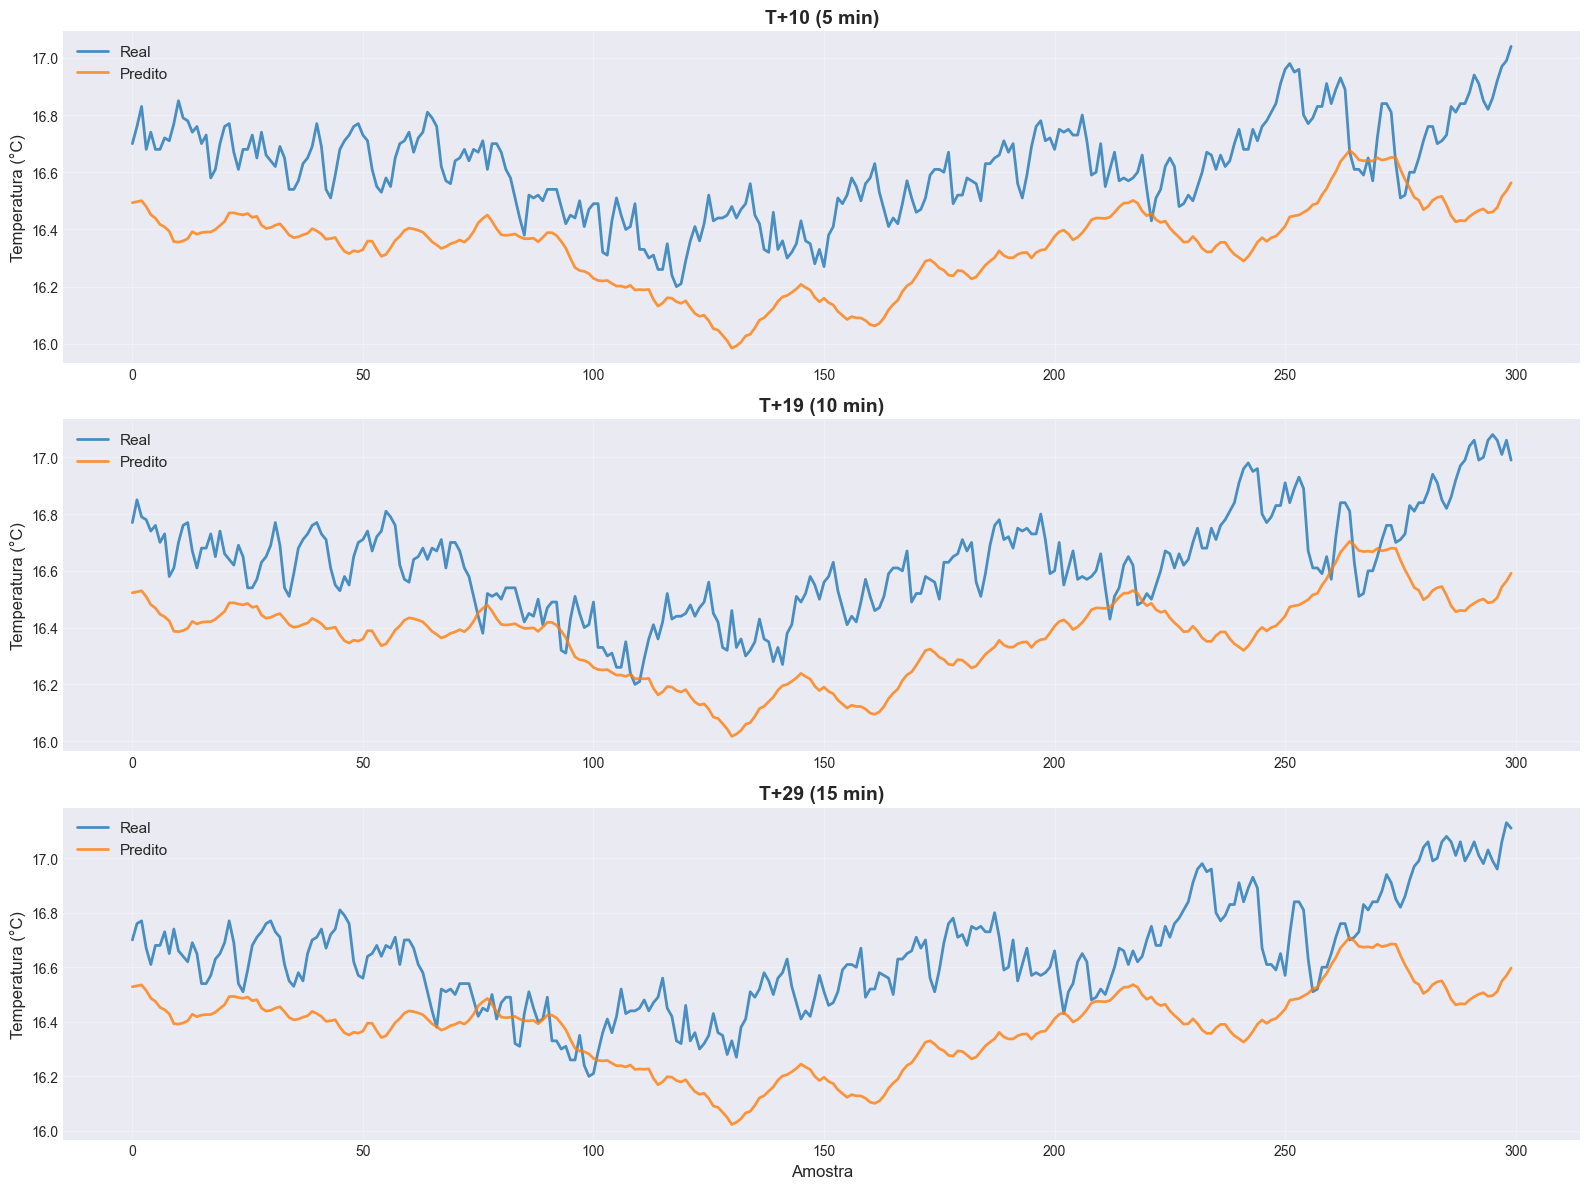

Gráfico salvo: images/LSTM/03_timeseries_predictions.png


In [15]:
# Plotar série temporal das predições
n_samples = 300
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.plot(y_test[:n_samples, i], label='Real', linewidth=2, alpha=0.8)
    ax.plot(y_pred[:n_samples, i], label='Predito', linewidth=2, alpha=0.8)
    ax.set_ylabel('Temperatura (°C)', fontsize=12)
    ax.set_title(horizon_name, fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

axes[2].set_xlabel('Amostra', fontsize=12)
plt.tight_layout()
plt.savefig('images/LSTM/03_timeseries_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/LSTM/03_timeseries_predictions.png')

## 4.4. Análise de Erros

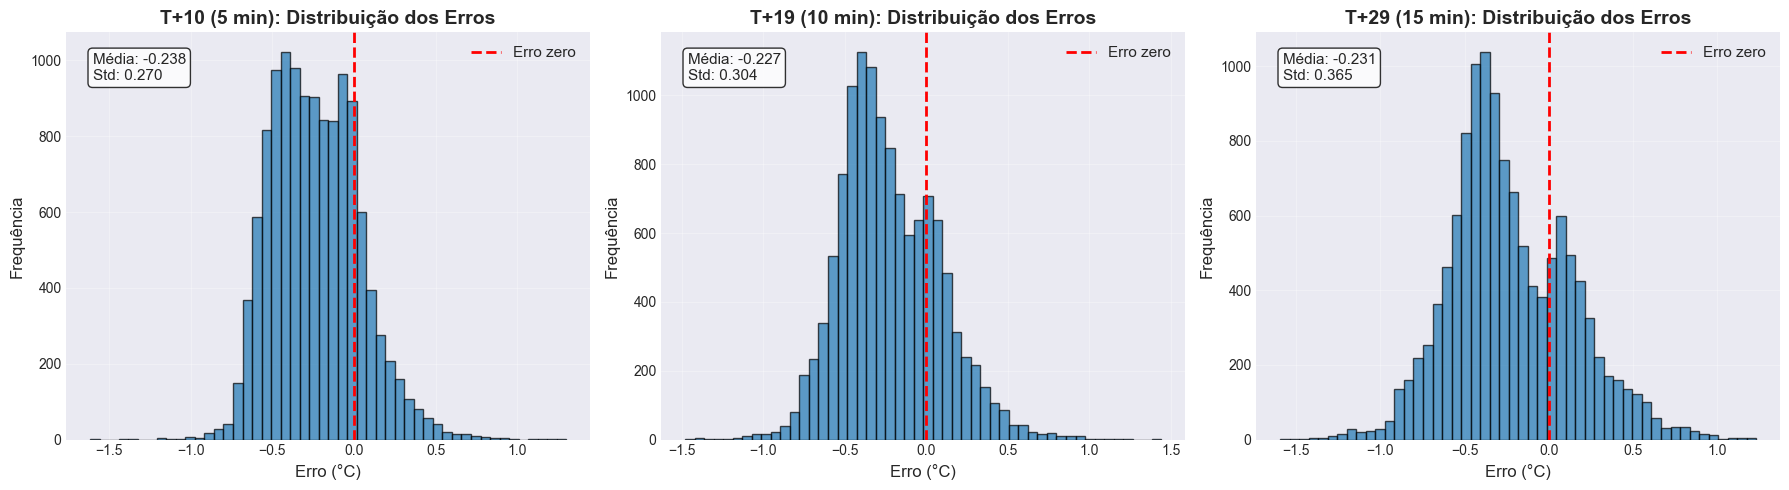

Gráfico salvo: images/LSTM/04_error_distribution.png


In [16]:
# Calcular erros
errors = y_pred - y_test

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (horizon_name, ax) in enumerate(zip(horizons_names, axes)):
    ax.hist(errors[:, i], bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Erro zero')
    ax.set_xlabel('Erro (°C)', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.set_title(f'{horizon_name}: Distribuição dos Erros', fontweight='bold', fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    mean_err = errors[:, i].mean()
    std_err = errors[:, i].std()
    ax.text(0.05, 0.95, f'Média: {mean_err:.3f}\nStd: {std_err:.3f}',
            transform=ax.transAxes, va='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('images/LSTM/04_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print('Gráfico salvo: images/LSTM/04_error_distribution.png')

# 5. Salvar Modelo

---

In [17]:
# Criar pasta models/LSTM se não existir
os.makedirs('models/LSTM', exist_ok=True)

# Salvar modelo Keras
model.save('models/LSTM/temperature_model.keras')
print('Modelo Keras salvo: models/LSTM/temperature_model.keras')

# Salvar scaler
joblib.dump(scaler, 'models/LSTM/scaler.pkl')
print('Scaler salvo: models/LSTM/scaler.pkl')

Modelo Keras salvo: models/LSTM/temperature_model.keras
Scaler salvo: models/LSTM/scaler.pkl
